# Modelling


In [ ]:
# import libraries
from pyspark.sql import functions as F
from pyspark.sql.functions import col, unix_timestamp, round, abs
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.feature import OneHotEncoder
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
import statsmodels.api as sm
import itertools
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import r2_score

In [2]:
spark = (
    SparkSession.builder.appName("TLC eda")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/09/03 19:35:19 WARN Utils: Your hostname, Tasneems-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 192.168.20.7 instead (on interface en0)
25/09/03 19:35:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/03 19:35:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/09/03 19:35:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/09/03 19:35:20 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


### Read and Prepare Data

In [3]:
# Read yellow cab data
yellow_24 = spark.read.parquet("../data/tlc_data/raw/cleaned/curated/dev/yellow_24.parquet")
yellow_25 = spark.read.parquet("../data/tlc_data/raw/cleaned/curated/dev/yellow_25.parquet")

# Read high-volume FHV data
hvfhv_24 = spark.read.parquet("../data/tlc_data/raw/cleaned/curated/dev/hvfhv_24.parquet")
hvfhv_25 = spark.read.parquet("../data/tlc_data/raw/cleaned/curated/dev/hvfhv_25.parquet")

In [4]:
yellow_25.printSchema()

root
 |-- pu_location_id: integer (nullable = true)
 |-- pu_zone: string (nullable = true)
 |-- fare_per_min: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)
 |-- do_location_id: integer (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- is_cbd: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- service_type: string (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- temperature: double (nullable = true)
 |-- avg_speed_mph: double (nullable = true)
 |-- fare_per_mile: double (nullable = true)
 |-- is_peak: integer (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- trip_time: double (nullable = true)
 |-- month: integer (null

In [5]:
yellow_24 = yellow_24.withColumn("service_type", F.lit("yellow"))
yellow_25 = yellow_25.withColumn("service_type", F.lit("yellow"))
hvfhv_24 = hvfhv_24.withColumn("service_type", F.lit("hvfhv"))
hvfhv_25 = hvfhv_25.withColumn("service_type", F.lit("hvfhv"))

In [6]:
yellow_24.withColumn("year", F.lit(2024))
yellow_25 = yellow_25.withColumn("year", F.lit(2025))
hvfhv_24 = hvfhv_24.withColumn("year", F.lit(2024))
hvfhv_25 = hvfhv_25.withColumn("year", F.lit(2025))

In [7]:
# Define the desired column order
cols_ordered = [
    "pu_zone",
    "do_location_id",
    "is_cbd",
    "service_type",        
    "pickup_datetime",
    "year",
    "month",
    "trip_time",
    "trip_miles",
    "fare_amount",
    "fare_per_mile",
    "fare_per_min",
    "cbd_congestion_fee",
    "congestion_surcharge",
    "is_peak",
    "is_weekend",
    "avg_speed_mph",
    "temperature",
    "wind_speed",
    "precipitation"
]

dfs = [yellow_24, yellow_25, hvfhv_24, hvfhv_25]

def prepare_df(df, cols_ordered):
    return df.select(cols_ordered)

dfs_prepared = [prepare_df(df, cols_ordered) for df in dfs]

all_df = dfs_prepared[0]
for df in dfs_prepared[1:]:
    all_df = all_df.union(df)


In [33]:
# Show the counts sorted by year and month
monthly_counts = all_df.groupBy("year", "month").agg(F.count("*").alias("record_count"))
monthly_counts.orderBy("year", "month").show()

+----+-----+------------+
|year|month|record_count|
+----+-----+------------+
|2024|    1|    24229725|
|2024|    2|    19894664|
|2024|    3|    25188360|
|2025|    1|    24580051|
|2025|    2|    24564688|
|2025|    3|    24909311|
+----+-----+------------+



## OLS Regression

### Aggregate to monthly level

In [41]:
agg_df = (all_df.groupBy("pu_zone", "is_cbd", "year", "month", "service_type")
          .agg(
              # Demand
              F.count("*").alias("trip_count"),
              # Traffic
              F.avg("avg_speed_mph").alias("avg_speed"),
              # Weather
              F.avg("temperature").alias("avg_temp"),
              F.avg("precipitation").alias("avg_precip"),
              F.avg("wind_speed").alias("avg_wind"),
              # Temporal
              F.avg(F.col("is_peak").cast("integer")).alias("peak_ratio"),
              F.avg(F.col("is_weekend").cast("integer")).alias("weekend_ratio"),
              # Trip/fare characteristics
              F.avg("fare_amount").alias("avg_fare"),
              F.avg("trip_miles").alias("avg_miles"),
              F.avg("trip_time").alias("avg_time"),
              F.avg("fare_per_mile").alias("avg_fare_per_mile"),
              
              # Fees
              F.avg("congestion_surcharge").alias("avg_congestion_surcharge"),
              F.avg("cbd_congestion_fee").alias("avg_cbd_congestion_fee")
          )
)


In [31]:
agg_df.show()

25/09/03 18:40:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+------+----+-----+------------+----------+------------------+------------------+--------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------------+----------------------+
|             pu_zone|is_cbd|year|month|service_type|trip_count|         avg_speed|          avg_temp|          avg_precip|          avg_wind|         peak_ratio|      weekend_ratio|          avg_fare|         avg_miles|          avg_time| avg_fare_per_mile|avg_congestion_surcharge|avg_cbd_congestion_fee|
+--------------------+------+----+-----+------------+----------+------------------+------------------+--------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------------+----------------------+
|       Rockaway Park|     0|2024|    2|      yellow|         1|             37

In [42]:
agg_df = agg_df.withColumn("year_2025", F.when(F.col("year") == 2025, 1).otherwise(0))


In [ ]:
# Count nulls in each column
agg_df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) 
    for c in agg_df.columns
]).show()


+-------+------+----+-----+------------+----------+---------+--------+----------+--------+----------+-------------+-----------------+----------------+------------------------+----------------------+---------+
|pu_zone|is_cbd|year|month|service_type|trip_count|avg_speed|avg_temp|avg_precip|avg_wind|peak_ratio|weekend_ratio|avg_fare_per_mile|avg_fare_per_min|avg_congestion_surcharge|avg_cbd_congestion_fee|year_2025|
+-------+------+----+-----+------------+----------+---------+--------+----------+--------+----------+-------------+-----------------+----------------+------------------------+----------------------+---------+
|      0|     0|   0|    0|           0|         0|        0|       0|         0|       0|         0|            0|                0|               0|                       0|                     0|        0|
+-------+------+----+-----+------------+----------+---------+--------+----------+--------+----------+-------------+-----------------+----------------+--------------

In [39]:
agg_df.groupBy("year", "month").count().show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2024|    3|  864|
|2024|    2|  865|
|2025|    3|  951|
|2024|    1|  851|
|2025|    1|  947|
|2025|    2|  944|
+----+-----+-----+



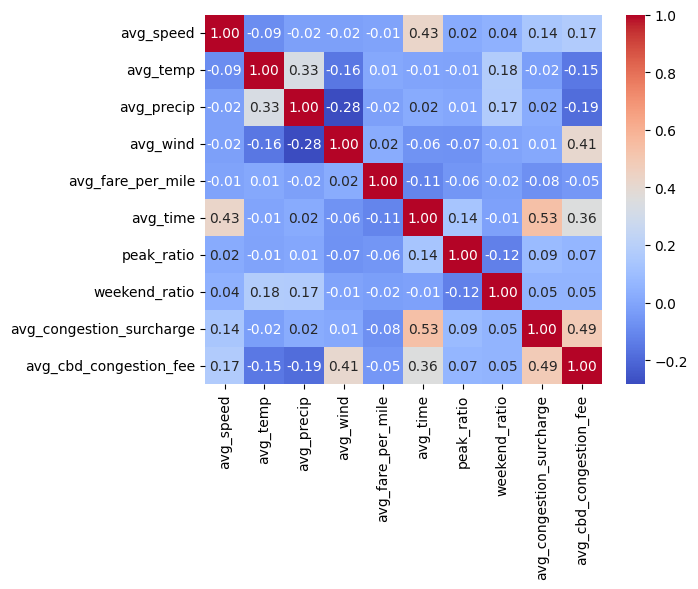

In [ ]:
# Plot heatmap
sns.heatmap(df_pd[cont_features].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [85]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_pd[cont_features]
X = sm.add_constant(X)  # add intercept
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                     feature       VIF
0                      const  1.000000
1                  avg_speed  1.264016
2                   avg_temp  1.168960
3                 avg_precip  1.228881
4                   avg_wind  1.376858
5          avg_fare_per_mile  1.017979
6                   avg_time  1.789351
7                 peak_ratio  1.046578
8              weekend_ratio  1.087110
9   avg_congestion_surcharge  1.708778
10    avg_cbd_congestion_fee  1.795964


### Train OLS Model

In [43]:

# Continuous features to standardize
cont_features = [
    "avg_speed", "avg_temp", "avg_precip", "avg_wind", 
    "avg_fare_per_mile", "avg_time", "peak_ratio", "weekend_ratio",
    "avg_congestion_surcharge", "avg_cbd_congestion_fee"
]


# collect to pandas
cols_to_collect = ["trip_count", "year_2025", "month", "is_cbd", "service_type"] + cont_features
df_pd = agg_df.select(cols_to_collect).toPandas()

# Convert boolean columns to int
bool_cols = df_pd.select_dtypes(include='bool').columns
df_pd[bool_cols] = df_pd[bool_cols].astype(int)


# Compute market share
# Total trips per year, month, CBD
df_pd['total_trips'] = df_pd.groupby(['year_2025','month','is_cbd'])['trip_count'].transform('sum')

# Market share per service_type
df_pd['market_share'] = df_pd['trip_count'] / df_pd['total_trips']

# Optional: logit transform to make DV unbounded
epsilon = 1e-6
df_pd['market_share_logit'] = np.log((df_pd['market_share'] + epsilon) / (1 - df_pd['market_share'] + epsilon))


#  Standardize continuous features
scaler = StandardScaler()
df_pd[cont_features] = scaler.fit_transform(df_pd[cont_features])


# Build OLS formula
formula = "market_share_logit ~ C(month) + year_2025 * C(service_type) * is_cbd"
formula += " + " + " + ".join(cont_features)


# Fit OLS regression
ols_model = smf.ols(formula=formula, data=df_pd).fit()


#  Summary output
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:     market_share_logit   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     676.6
Date:                Wed, 03 Sep 2025   Prob (F-statistic):               0.00
Time:                        18:42:44   Log-Likelihood:                -10861.
No. Observations:                5422   AIC:                         2.176e+04
Df Residuals:                    5403   BIC:                         2.189e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [87]:
# Training set: 2024
X_train = df_pd[df_pd['year_2025'] == 0].drop(columns=['market_share_logit'])
y_train = df_pd[df_pd['year_2025'] == 0]['market_share_logit']

# Test set: 2025
X_test = df_pd[df_pd['year_2025'] == 1].drop(columns=['market_share_logit'])
y_test = df_pd[df_pd['year_2025'] == 1]['market_share_logit']

In [ ]:
categorical_cols = ['service_type', 'month', 'is_cbd']
numerical_cols = ['avg_speed', 'avg_temp', 'avg_precip', 'avg_wind',
                  'avg_fare_per_mile', 'avg_time', 'peak_ratio', 
                  'weekend_ratio', 'avg_congestion_surcharge', 'avg_cbd_congestion_fee']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])


ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5))
])

ridge_pipeline.fit(X_train, y_train)

# Predict & evaluate
y_pred = ridge_pipeline.predict(X_test)
print("R² on test set:", r2_score(y_test, y_pred))


R² on test set: 0.570143783980262


In [89]:
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(alphas=[0.001, 0.01, 0.1, 1.0], cv=5, max_iter=10000))
])

lasso_pipeline.fit(X_train, y_train)

y_pred_lasso = lasso_pipeline.predict(X_test)
print("R² on test set (Lasso):", r2_score(y_test, y_pred_lasso))

R² on test set (Lasso): 0.5933549631080453


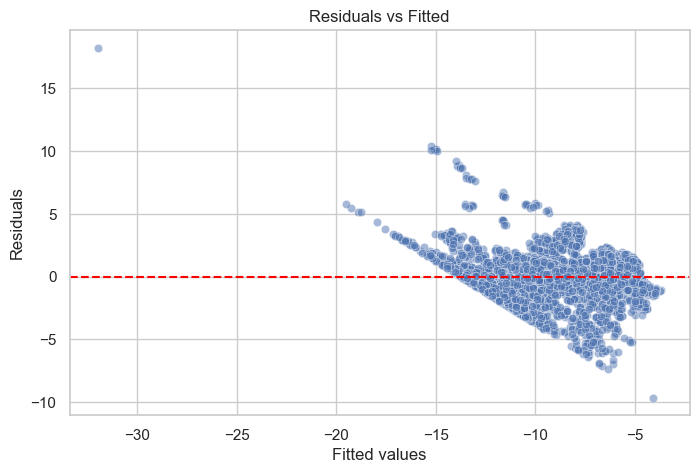

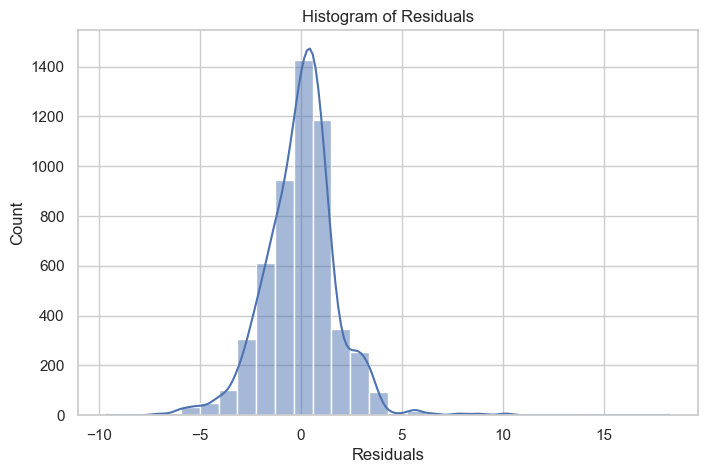

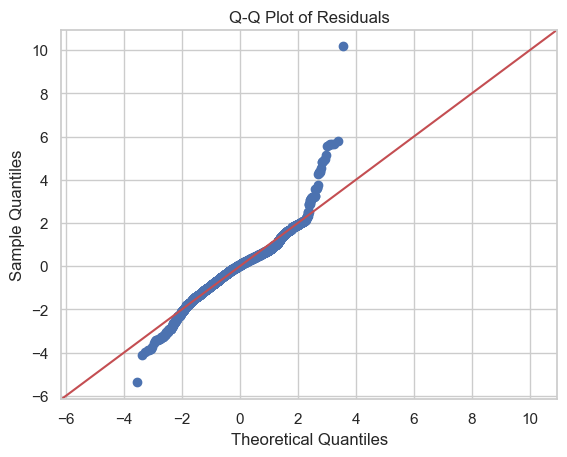

Shapiro-Wilk test: W=0.959, p=1.05e-36
Residuals deviate from normality
Durbin-Watson statistic: 1.923


/Users/tasneemzulaiqa/Documents/GitHub/project-1-individual-tasneemzulaiqa/proj1_env/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5422.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
#  Residuals
residuals = ols_model.resid
fitted = ols_model.fittedvalues

# Plot residuals vs fitted values (check homoskedasticity) 
plt.figure(figsize=(8,5))
sns.scatterplot(x=fitted, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

# Histogram of residuals (check normality) 
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")
plt.show()

# Q-Q plot for residuals 
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Shapiro-Wilk test for normality 
from scipy.stats import shapiro
stat, p = shapiro(residuals)
print(f"Shapiro-Wilk test: W={stat:.3f}, p={p:.3g}")
if p > 0.05:
    print("Residuals roughly normal")
else:
    print("Residuals deviate from normality")

#  Durbin-Watson test for autocorrelation 
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw:.3f}")


## Random Forest Regression

### Aggregate to Daily Level

In [ ]:
daily_agg = (all_df.groupBy(
        "service_type",           
        "pu_zone",                  
        "is_cbd",                  
        F.to_date("pickup_datetime").alias("date"),
        F.dayofweek("pickup_datetime").alias("day_of_week")             
    ).agg(
        # Demand
        F.count("*").alias("trip_count"),
        # Traffic
        F.avg("avg_speed_mph").alias("avg_speed"),
        # Weather
        F.avg("temperature").alias("avg_temp"),
        F.avg("precipitation").alias("avg_precip"),
        F.avg("wind_speed").alias("avg_wind"),
        # Temporal
        F.avg(F.col("is_peak").cast("integer")).alias("peak_ratio"),

        F.avg("trip_time").alias("avg_time"),
        F.avg("fare_per_mile").alias("avg_fare_per_mile"),
        # Fees
        F.avg("congestion_surcharge").alias("avg_congestion_surcharge"),
        F.avg("cbd_congestion_fee").alias("avg_cbd_congestion_fee")
          )
)

daily_agg = (daily_agg
    .withColumn("year", F.year("date"))
    .withColumn("month", F.month("date"))
    .withColumn("is_2025", F.when(F.col("year") == 2025, 1).otherwise(0))
    .withColumn("is_weekend", F.when(F.col("day_of_week").isin([1,7]), 1).otherwise(0))  
)


In [9]:
daily_agg.printSchema()

root
 |-- service_type: string (nullable = false)
 |-- pu_zone: string (nullable = true)
 |-- is_cbd: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- trip_count: long (nullable = false)
 |-- avg_speed: double (nullable = true)
 |-- avg_temp: double (nullable = true)
 |-- avg_precip: double (nullable = true)
 |-- avg_wind: double (nullable = true)
 |-- peak_ratio: double (nullable = true)
 |-- avg_time: double (nullable = true)
 |-- avg_fare_per_mile: double (nullable = true)
 |-- avg_congestion_surcharge: double (nullable = true)
 |-- avg_cbd_congestion_fee: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- is_2025: integer (nullable = false)
 |-- is_weekend: integer (nullable = false)



### Predict Market Share

In [ ]:
# Train: Jan-Feb 2024
train_df = daily_agg.filter((F.col("year") == 2024) & (F.col("month") <= 2))
# Validation: Mar 2024
val_df   = daily_agg.filter((F.col("year") == 2024) & (F.col("month") == 3))
# Test: all 2025
test_df  = daily_agg.filter(F.col("year") == 2025)


#  Convert to Pandas

train_pdf = train_df.toPandas()
val_pdf   = val_df.toPandas()
test_pdf  = test_df.toPandas()

In [ ]:
def add_market_share(pdf):
    
    """
    computes market share 
    """
    pdf = pdf.copy()
    # total trips per pu_zone/date
    total_trips = pdf.groupby(["pu_zone","date"])["trip_count"].transform("sum")
    pdf["market_share"] = pdf["trip_count"] / total_trips
    return pdf

train_pdf = add_market_share(train_df.toPandas())
val_pdf   = add_market_share(val_df.toPandas())
test_pdf  = add_market_share(test_df.toPandas())

#  Define features and target

target = "market_share"  

categorical_cols = ["service_type", "pu_zone", "day_of_week", "month"]
numerical_cols = ['avg_speed', 'avg_temp', 'avg_precip', 'avg_wind',
                  'avg_fare_per_mile', 'avg_time', 'peak_ratio', 'avg_congestion_surcharge', 'avg_cbd_congestion_fee']


#  One-hot encoding + RF pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numerical_cols)
    ]
)

rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    ))
])


#  Fit model

rf_model.fit(train_pdf[categorical_cols + numerical_cols], train_pdf[target])


#  Evaluate using market share RMSE

for split_name, df in zip(["Train", "Validation", "Test"], [train_pdf, val_pdf, test_pdf]):
    preds = rf_model.predict(df[categorical_cols + numerical_cols])
    rmse = np.sqrt(mean_squared_error(df[target], preds))
    print(f"{split_name} Market-Share RMSE: {rmse:.4f}")

Train Market-Share RMSE: 0.0428
Validation Market-Share RMSE: 0.0519
Test Market-Share RMSE: 0.1712


In [ ]:
# Get feature names after one-hot encoding
cat_features = rf_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_features = np.concatenate([cat_features, numerical_cols])

importances = rf_model.named_steps['rf'].feature_importances_
importance_df = pd.DataFrame({"feature": all_features, "importance": importances}).sort_values("importance", ascending=False)
print(importance_df.head(10))


                      feature  importance
278  avg_congestion_surcharge    0.453908
0          service_type_hvfhv    0.232077
1         service_type_yellow    0.192953
275         avg_fare_per_mile    0.075819
276                  avg_time    0.008299
271                 avg_speed    0.002927
42       pu_zone_Central Park    0.002223
192   pu_zone_Randalls Island    0.001953
11       pu_zone_Battery Park    0.001698
137   pu_zone_Lenox Hill East    0.001672


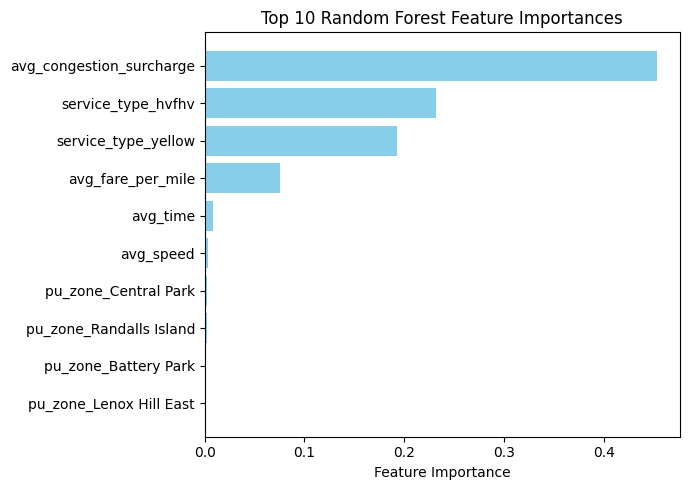

In [14]:

# Get top 10 features
top10 = importance_df.head(10)

# Plot horizontal bar chart
plt.figure(figsize=(7, 5))
plt.barh(top10["feature"], top10["importance"], color="skyblue")
plt.gca().invert_yaxis()  
plt.xlabel("Feature Importance")
plt.title("Top 10 Random Forest Feature Importances")
plt.tight_layout()
plt.show()


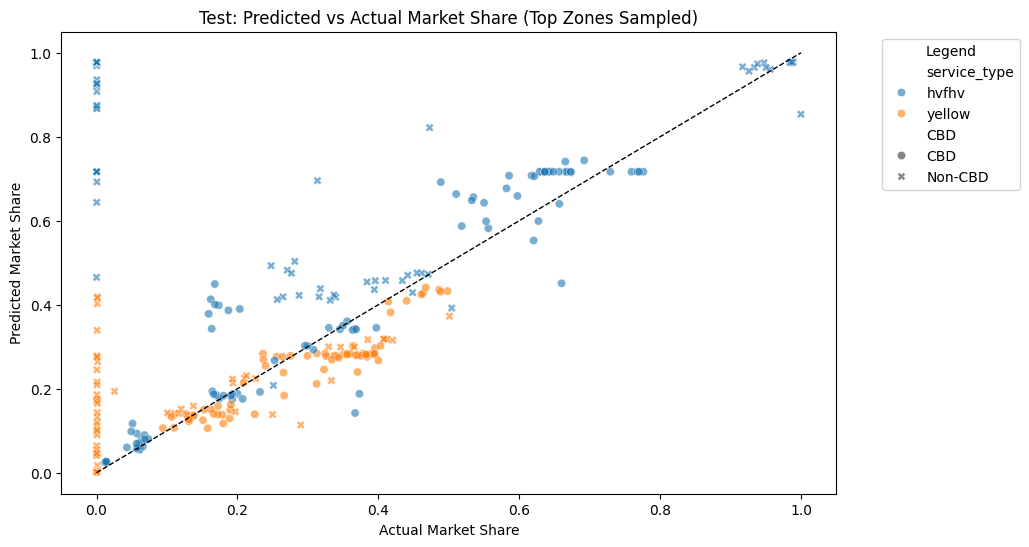

In [ ]:
def plot_pred_vs_actual_sampled(df, model, n_zones=5, sample_frac=0.5, split_name="Test"):
    
    """
    Plot predicted vs actual market share for top zones, sampling rows to reduce clutter.

    Parameters:
    -----------
    df :  Data containing actual market share and features.
    model : Fitted model
    n_zones : int
        Number of top pickup zones to include per CBD/non-CBD category.
    sample_frac : Fraction of rows to sample for plotting.
    split_name :  Name of the data split (e.g., "Test", "Train") for the plot title.
    """
    
    df = df.copy()
    df['pred_market_share'] = model.predict(df[categorical_cols + numerical_cols])
    
    df['CBD'] = df['is_cbd'].map({0: "Non-CBD", 1: "CBD"})
    
    # Select top zones by total trips per CBD/non-CBD
    top_zones = (df.groupby(['CBD', 'pu_zone'])['trip_count']
                   .sum()
                   .groupby(level=0, group_keys=False)
                   .nlargest(n_zones)
                   .reset_index()['pu_zone']
                   .tolist())
    
    df = df[df['pu_zone'].isin(top_zones)]
    
    # Sample fraction of rows to reduce clutter
    df = df.sample(frac=sample_frac, random_state=42)
    
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=df,
        x='market_share',
        y='pred_market_share',
        hue='service_type',
        style='CBD',
        alpha=0.6
    )
    
    plt.plot([0,1], [0,1], 'k--', linewidth=1)
    plt.xlabel("Actual Market Share")
    plt.ylabel("Predicted Market Share")
    plt.title(f"{split_name}: Predicted vs Actual Market Share (Top Zones Sampled)")
    plt.legend(title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Use it on test set
plot_pred_vs_actual_sampled(test_pdf, rf_model, n_zones=5, sample_frac=0.1)
